In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import importlib
import os
import matplotlib.patches as patches
import dask
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SGECluster
import socket
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization

In [2]:
hostname = socket.gethostname()
n_workers = 1
n_cores = 4

wks2 = "wn-wks2.fe.hhi.de"
gpu1 = "wn-gpu1.fe.hhi.de"
gpu2 = "wn-gpu-104-01.fe.hhi.de"

if hostname == wks2:
    path = "/data/cluster/projects/infineon-radar/daq_x-har/3_Walking_converted/recording-2020-01-28_11-31-55"
    mem = "20G"      # Allocated memory is critical. For this example it must be at least 16GB 
    q = "wn-37.q"    # Check current queue status on https://hpc-management.fe.hhi.de/wn/phpqstat/
    
    cluster = SGECluster(n_workers=n_workers, cores=n_cores, memory=mem,
                        resource_spec=f"h_vmem={mem}", host=hostname, queue=q,
                         job_extra=["-v MKL_NUM_THREADS=1,NUMEXPR_NUM_THREADS=1,OMP_NUM_THREADS=1"])
elif hostname in (gpu1, gpu2):
    path = os.getcwd() + "/data"
    os.environ["CUDA_VISIBLE_DEVICES"]="3"  # Check current status with nvidia-smi and pick GPU from 0-3
    cluster = LocalCluster(n_workers=n_workers, threads_per_worker=n_cores, host=hostname)
else:
    raise ValueError(f"{hostname} is not a supported host. Please run this example on {wks}, {gpu1} or {gpu2}.")
    

    
client = Client(cluster)
client.wait_for_workers(n_workers=n_workers)
client

Client Scheduler: tcp://127.0.0.1:37727 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 540.71 GB


In [ ]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 >= validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 < validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

def data_prep(path):
    dataset_raw = np.load(path, allow_pickle=True)
    arrays = np.array(dataset_raw[()]["data"])
    arrays = arrays - arrays.min()
    arrays = arrays/arrays.max()
    arrays -= arrays.mean()
    arrays = arrays/arrays.std()
    if np.isnan(arrays).any() or np.isinf(arrays).any():
        raise "data have imperfections"
    print(arrays.shape)
    labels = dataset_raw[()]["label"]
    labels = np.array([x-np.array(list(set(labels))).min() for x in labels])
    print(labels.shape)
    return (arrays, labels)

def load_data(path):
    data, label = data_prep(path)
    dataset = tf.data.Dataset.from_tensor_slices((data, label))
    dataset = dataset.shuffle(100000)
    train_dataset, rest = split_dataset(dataset, 0.3)
    test_dataset, valid_dataset = split_dataset(rest, 0.5)
    train_data = train_dataset.shuffle(1000).batch(10)
    valid_data = valid_dataset.batch(10)
    test_data = test_dataset.batch(10)
    return train_data, valid_data, test_data


def make_model():
    model = tf.keras.Sequential([
    Input((1,30,30)),
    Conv2D(filters = 8, kernel_size=(3,3), padding="same", activation="relu", name="c1", data_format="channels_first"),
    Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu", name="c2", data_format="channels_first"),
    MaxPool2D(pool_size=(2,2), strides=(1,1),padding="same", name="m1", data_format="channels_first"),
    
    Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu", name="c3", data_format="channels_first"),
    MaxPool2D(pool_size=(2,2), strides=(1,1),padding="same", name="m2",data_format="channels_first"),
    
    Flatten(),
    Dense(256, activation="relu", use_bias=True),
    Dense(5, activation="softmax", use_bias=True)])
    return model



In [85]:
train_data, valid_data, test_data = load_data("/home/fe/khodabakhshandeh/Projects/radar/radar-ml/Python/data/Config G/box_data.npy")

(59003, 1, 30, 30)
(59003,)


In [ ]:
model = make_model()
print(model.summary())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(train_data, verbose=1, validation_data=valid_data, epochs=20)

In [115]:
# model.save("base_model_2")
model.evaluate(test_data)

    885/Unknown - 2s 2ms/step - loss: 0.0989 - accuracy: 0.9655

[0.09893597595326135, 0.9655367]

In [109]:
# model = tf.keras.models.load_model("base_model")

In [88]:
def select_random_data(train_data):
    train_data.shuffle(1000)
    _, data = split_dataset(train_data, 0.1)
    return data

def UCB1(mu, n, t):
    P = np.sqrt(2*np.log10(t)/n)
    P = P
    print("p:", P)
    index = np.argmax(np.add(mu, P))
    return index

In [89]:
T = 100
W = model.layers[-2].get_weights()
n = np.zeros(20)
mu = np.zeros_like(n)
threshold = 0.005
norm_const=0.01
for i in range(1, T):
    #select random train data for comparison
    data = select_random_data(train_data)
    
    #selecting index exploration/exploitation
    if np.where(n==0)[0].size == 0:
        index = UCB1(mu, n, i)
        print("RL")
    else:
        index = np.where(n==0)[0][0]
    
    print("index:", index)
    
    #evaluating main model
    loss_base = model.evaluate(data)[0]
    print("/n")

    
    #setting selected node to zero and evaluating again
    W_ = np.copy(W)
    W_[0][:, index] = 0
    model.layers[-3].set_weights(W_)
    loss = model.evaluate(data)[0]
    print("/n")
    
    #calculating delta and reward
    delta = loss_base - loss
    reward = max(0, threshold + delta)/norm_const
    print("reward:", reward)
    
    #updating number of visiting the node and the average reward
    n[index] = n[index]+1
    print("n:", n)
    mu[index] = ((n[index]-1)/n[index])*mu[index] + (1/n[index])*reward
    print("mu:", mu)
    print("##############")
    #initializing the layer to the original trained weights for next round
    model.layers[-3].set_weights(W)
    
    
    

index: 0
    420/Unknown - 1s 3ms/step - loss: 0.1287 - accuracy: 0.9474/n
    420/Unknown - 1s 3ms/step - loss: 0.1466 - accuracy: 0.9433/n
reward: 0.0
n: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
##############
index: 1
    420/Unknown - 1s 3ms/step - loss: 0.1352 - accuracy: 0.9469/n
    420/Unknown - 1s 3ms/step - loss: 0.1464 - accuracy: 0.9440/n
reward: 0.0
n: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
##############
index: 2
    420/Unknown - 1s 3ms/step - loss: 0.1361 - accuracy: 0.9455/n
    420/Unknown - 1s 3ms/step - loss: 0.1339 - accuracy: 0.9483/n
reward: 0.7246987159361141
n: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mu: [0.         0.         0.72469872 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

index: 19
    420/Unknown - 1s 3ms/step - loss: 0.1544 - accuracy: 0.9383- 1s 4 - 1s 3ms/step - loss: 0.1591 - accuracy: 0.93 - 1s 3ms/step - - 1s 3ms/step - los - 1s 3ms/step - loss: 0.1589 - accuracy/n
    420/Unknown - 1s 3ms/step - loss: 0.1527 - accuracy: 0.9390/n
reward: 0.6695053785806533
n: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
mu: [0.         0.         0.72469872 0.         0.         0.28062477
 1.13377403 0.78878476 0.98224561 0.         1.79163509 0.11580196
 0.         0.29430705 0.69948246 0.         0.37405272 1.10125967
 1.30623202 0.66950538]
##############
p: [1.62617299 1.62617299 1.62617299 1.62617299 1.62617299 1.62617299
 1.62617299 1.62617299 1.62617299 1.62617299 1.62617299 1.62617299
 1.62617299 1.62617299 1.62617299 1.62617299 1.62617299 1.62617299
 1.62617299 1.62617299]
RL
index: 10
    420/Unknown - 1s 3ms/step - loss: 0.1493 - accuracy: 0.9431/n
    420/Unknown - 1s 3ms/step - loss: 0.1579 - accuracy: 0.9376/n
reward: 0.0
n: [1. 1.

p: [1.7350216  1.7350216  1.22684554 1.7350216  1.7350216  1.7350216
 1.22684554 1.22684554 1.22684554 1.7350216  1.00171519 1.7350216
 1.7350216  1.7350216  1.22684554 1.7350216  1.7350216  1.22684554
 1.00171519 1.22684554]
RL
index: 16
    420/Unknown - 2s 4ms/step - loss: 0.1442 - accuracy: 0.9431/n
    420/Unknown - 2s 4ms/step - loss: 0.1510 - accuracy: 0.9381/n
reward: 0.0
n: [1. 1. 2. 1. 1. 1. 2. 2. 2. 1. 3. 1. 1. 1. 2. 1. 2. 2. 3. 2.]
mu: [0.         0.         0.36234936 0.         0.         0.28062477
 0.56688701 0.62900421 0.4911228  0.         0.76353371 0.11580196
 0.         0.29430705 0.73876854 0.         0.18702636 0.8318628
 0.88911801 0.33475269]
##############
p: [1.74270706 1.74270706 1.23227998 1.74270706 1.74270706 1.74270706
 1.23227998 1.23227998 1.23227998 1.74270706 1.00615239 1.74270706
 1.74270706 1.74270706 1.23227998 1.74270706 1.23227998 1.23227998
 1.00615239 1.23227998]
RL
index: 17
    420/Unknown - 1s 4ms/step - loss: 0.1532 - accuracy: 0.9410/n
  

p: [1.81298245 1.81298245 1.28197218 1.81298245 1.81298245 1.28197218
 1.28197218 1.0467259  1.28197218 1.81298245 1.0467259  1.28197218
 1.81298245 1.0467259  1.0467259  1.81298245 1.28197218 0.90649122
 0.74014698 1.28197218]
RL
index: 6
    420/Unknown - 1s 3ms/step - loss: 0.1499 - accuracy: 0.9400- 1s 3ms/step - loss: 0./n
    420/Unknown - 1s 3ms/step - loss: 0.1542 - accuracy: 0.9395/n
reward: 0.07367913315205711
n: [1. 1. 2. 1. 1. 2. 3. 3. 2. 1. 3. 2. 1. 3. 3. 1. 2. 4. 6. 2.]
mu: [0.         0.         0.36234936 0.         0.         0.52534516
 0.40248439 0.67524485 0.4911228  0.         0.76353371 0.3125655
 0.         0.68908367 0.78882054 0.         0.18702636 0.89177447
 1.05267591 0.33475269]
##############
p: [1.81835778 1.81835778 1.28577312 1.81835778 1.81835778 1.28577312
 1.04982936 1.04982936 1.28577312 1.81835778 1.04982936 1.28577312
 1.81835778 1.04982936 1.04982936 1.81835778 1.28577312 0.90917889
 0.74234146 1.28577312]
RL
index: 14
    420/Unknown - 2s 4ms/st

    420/Unknown - 1s 3ms/step - loss: 0.1515 - accuracy: 0.9405/n
reward: 1.5303600957351084
n: [2. 2. 2. 2. 2. 3. 3. 3. 2. 2. 4. 2. 2. 3. 4. 2. 2. 5. 6. 2.]
mu: [0.38837478 0.         0.36234936 0.20246333 0.         0.7073976
 0.40248439 0.67524485 0.4911228  0.15018828 0.87318472 0.3125655
 0.26050893 0.68908367 0.62474723 0.1285798  0.18702636 1.01949159
 1.05267591 0.33475269]
##############
p: [1.32219062 1.32219062 1.32219062 1.32219062 1.32219062 1.07956412
 1.07956412 1.07956412 1.32219062 1.32219062 0.93492995 1.32219062
 1.32219062 1.07956412 0.93492995 1.32219062 1.32219062 0.83622677
 0.76336711 1.32219062]
RL
index: 17
    420/Unknown - 1s 3ms/step - loss: 0.1544 - accuracy: 0.9395/n
    420/Unknown - 1s 3ms/step - loss: 0.1513 - accuracy: 0.9374/n
reward: 0.8140019485207258
n: [2. 2. 2. 2. 2. 3. 3. 3. 2. 2. 4. 2. 2. 3. 4. 2. 2. 6. 6. 2.]
mu: [0.38837478 0.         0.36234936 0.20246333 0.         0.7073976
 0.40248439 0.67524485 0.4911228  0.15018828 0.87318472 0.3125655

p: [1.35132335 1.35132335 1.35132335 1.35132335 1.35132335 0.95552991
 1.1033509  0.95552991 1.1033509  1.35132335 0.85465193 1.35132335
 1.35132335 0.95552991 0.95552991 1.35132335 1.35132335 0.7801869
 0.57620621 1.35132335]
RL
index: 17
    420/Unknown - 1s 3ms/step - loss: 0.1490 - accuracy: 0.9431/n
    420/Unknown - 1s 4ms/step - loss: 0.1556 - accuracy: 0.9381/n
reward: 0.0
n: [ 2.  2.  2.  2.  2.  4.  3.  4.  3.  2.  5.  2.  2.  4.  4.  2.  2.  7.
 11.  2.]
mu: [0.38837478 0.         0.36234936 0.20246333 0.         0.79989089
 0.40248439 0.50643364 0.47493419 0.15018828 0.79413743 0.3125655
 0.26050893 0.57174725 0.62474723 0.1285798  0.18702636 0.84449427
 1.1822249  0.33475269]
##############
p: [1.35370193 1.35370193 1.35370193 1.35370193 1.35370193 0.95721181
 1.105293   0.95721181 1.105293   1.35370193 0.85615627 1.35370193
 1.35370193 0.95721181 0.95721181 1.35370193 1.35370193 0.72358412
 0.57722044 1.35370193]
RL
index: 18
    420/Unknown - 1s 3ms/step - loss: 0.1449 -

    420/Unknown - 1s 4ms/step - loss: 0.1525 - accuracy: 0.9410/n
    420/Unknown - 1s 3ms/step - loss: 0.1554 - accuracy: 0.9379/n
reward: 0.20820587239272725
n: [ 3.  2.  5.  2.  2.  5.  3.  4.  3.  2.  5.  6.  2.  4.  4.  2.  2.  7.
 12.  3.]
mu: [0.25891652 0.         0.80928282 0.20246333 0.         0.78198589
 0.40248439 0.50643364 0.47493419 0.15018828 0.79413743 0.84485457
 0.26050893 0.57174725 0.62474723 0.1285798  0.18702636 0.84449427
 1.08943639 0.45666766]
##############
p: [1.12475985 1.37754386 0.87123524 1.37754386 1.37754386 0.87123524
 1.12475985 0.97407061 1.12475985 1.37754386 0.87123524 0.79532532
 1.37754386 0.97407061 0.97407061 1.37754386 1.37754386 0.73632817
 0.56237993 1.12475985]
RL
index: 2
    420/Unknown - 1s 4ms/step - loss: 0.1492 - accuracy: 0.9374/n
    420/Unknown - 2s 4ms/step - loss: 0.1496 - accuracy: 0.9374/n
reward: 0.46686298819397465
n: [ 3.  2.  6.  2.  2.  5.  3.  4.  3.  2.  5.  6.  2.  4.  4.  2.  2.  7.
 12.  3.]
mu: [0.25891652 0.      

p: [1.14141506 1.39794224 0.80710233 1.39794224 1.39794224 0.65899629
 1.14141506 0.98849444 0.98849444 1.39794224 0.80710233 0.74723156
 1.14141506 0.98849444 0.8841363  1.39794224 1.39794224 0.74723156
 0.54831806 1.14141506]
RL
index: 3
    420/Unknown - 1s 3ms/step - loss: 0.1521 - accuracy: 0.9388/n
    420/Unknown - 1s 3ms/step - loss: 0.1465 - accuracy: 0.9407/n
reward: 1.0585650982019241
n: [ 3.  2.  6.  3.  2.  9.  3.  4.  4.  2.  6.  7.  3.  4.  5.  2.  2.  7.
 13.  3.]
mu: [0.25891652 0.         0.75221285 0.48783058 0.         0.8975856
 0.40248439 0.50643364 0.35620064 0.15018828 0.66178119 0.83178396
 0.22713759 0.57174725 0.49979778 0.1285798  0.18702636 0.84449427
 1.00563359 0.45666766]
##############
p: [1.14281564 1.3996576  0.80809269 1.14281564 1.3996576  0.65980492
 1.14281564 0.98970738 0.98970738 1.3996576  0.80809269 0.74814846
 1.14281564 0.98970738 0.88522119 1.3996576  1.3996576  0.74814846
 0.54899088 1.14281564]
RL
index: 3
    420/Unknown - 1s 3ms/step - 

In [94]:
n

array([ 3.,  2.,  7.,  4.,  2.,  9.,  3.,  4.,  4.,  2.,  6.,  8.,  3.,
        6.,  5.,  2.,  3.,  8., 13.,  5.])

In [95]:
np.argsort(mu)

array([ 1,  4, 16, 15,  9, 12,  0,  8,  3,  6, 19, 14,  7, 10, 13, 17, 11,
        5,  2, 18])

In [104]:
# W_ = np.copy(W)
# # W_[0][:, 18] = 0
# # W_[0][:, 2] = 0
# # W_[:, 13] = 0
# model.layers[-3].set_weights(W_)
model.evaluate(test_data)

    885/Unknown - 2s 2ms/step - loss: 0.1561 - accuracy: 0.9364

[0.15614040915702262, 0.9363842]

[1.         0.70710678 0.57735027 0.5        0.4472136  0.40824829
 0.37796447 0.35355339 0.33333333 0.31622777 0.30151134 0.28867513
 0.2773501  0.26726124 0.25819889 0.25       0.24253563 0.23570226
 0.22941573 0.2236068  0.21821789 0.21320072 0.20851441 0.20412415
 0.2        0.19611614 0.19245009 0.18898224 0.18569534 0.18257419
 0.1796053  0.1767767  0.17407766 0.17149859 0.16903085 0.16666667
 0.16439899 0.16222142 0.16012815 0.15811388 0.15617376 0.15430335
 0.15249857 0.15075567 0.1490712  0.14744196 0.14586499 0.14433757
 0.14285714 0.14142136 0.14002801 0.13867505 0.13736056 0.13608276
 0.13483997 0.13363062 0.13245324 0.13130643 0.13018891 0.12909944
 0.12803688 0.12700013 0.12598816 0.125      0.12403473 0.12309149
 0.12216944 0.12126781 0.12038585 0.11952286 0.11867817 0.11785113
 0.11704115 0.11624764 0.11547005 0.11470787 0.11396058 0.1132277
 0.11250879 0.1118034  0.11111111 0.11043153 0.10976426 0.10910895
 0.10846523 0.10783277 0.10721125 0.10660036 0.10599979 0.10540

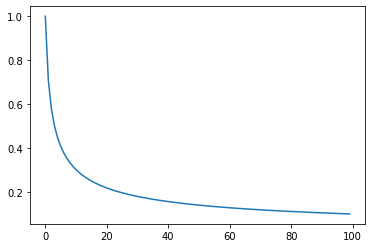

In [84]:
a = np.arange(100)+1
t = sum(a)
p=np.sqrt(2*np.log10(t)/a)
pp = p/p.max()
print(pp)
plt.plot(pp)

In [70]:
p+m

array([2.6130902 , 1.93131806, 1.65854132, 1.93131806, 1.60969079])

In [67]:
mu[argmax(mu)]

NameError: name 'argmax' is not defined

In [92]:
a = np.array([1,2,3,3,2,1,1,1])
a[2] +=1

In [79]:
len(model.layers[-3].get_weights())

2